In [4]:
import gym
for env_spec in gym.envs.registry.all():
    env_name = env_spec.id
    if 'Space' in env_name:
        print(env_name)

SpaceInvaders-v0
SpaceInvaders-ram-v4
SpaceInvaders-ramDeterministic-v4
SpaceInvadersNoFrameskip-v4
SpaceInvadersDeterministic-v4
SpaceInvaders-v4
SpaceInvaders-ramNoFrameskip-v0
SpaceInvadersDeterministic-v0
SpaceInvaders-ramNoFrameskip-v4
SpaceInvaders-ram-v0
SpaceInvaders-ramDeterministic-v0
SpaceInvadersNoFrameskip-v0


## Development of loss for VAE training

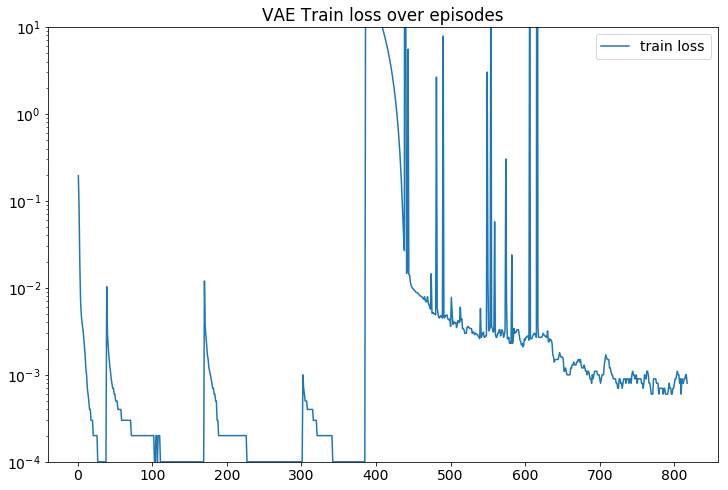

In [5]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 14})

# Read training statistics out of the log file.
RUN_NAME = 'sequential_training_wide_shots'
RESULTS_DIR = 'results/{}'.format(RUN_NAME)
vae_log_fn = ('{}/vae_training.log'
              .format(RESULTS_DIR))
training_statistics_pre_df = {}
with open(vae_log_fn, 'r') as f:
    epoch = -1
    walltime = -1
    train_loss = -1
    
    for line in f.readlines():
        if 'Started Epoch' in line:
            epoch = int(line.strip().split(' ')[-1])
        if 'Walltime:' in line:
            walltime = float(line.strip().split(' ')[-1])
        if 'Train loss:' in line:
            train_loss = float(line.strip().split(' ')[-1])
            # Train loss should be the last entry per episode
            entry = {'walltime [s]': walltime,
                     'train loss': train_loss}
            training_statistics_pre_df[epoch] = entry

# Plot the training progress
vae_training_statisitcs = pd.DataFrame(training_statistics_pre_df).T
_ = vae_training_statisitcs.plot(y='train loss',
                                 logy=True,
                                 ylim=(0.0001, 10.),
                                 title='VAE Train loss over episodes',
                                 figsize=(12, 8))

## Development of reward over generations for agent training

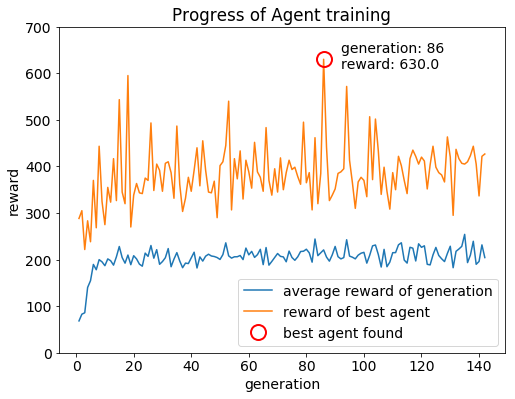

In [6]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 14})

# Read training statistics out of the log file.
RUN_NAME = 'sequential_training'
RESULTS_DIR = 'results/{}'.format(RUN_NAME)
agent_log_fn = ('{}/agent_training.log'
              .format(RESULTS_DIR))
training_statistics_pre_df = {}
with open(agent_log_fn, 'r') as f:
    generation = -1
    walltime = -1
    reward_mean = -1
    reward_max = -1
    reward_std = -1
    
    for line in f.readlines():
        if 'canidates of generation' in line:
            generation = int(line.strip().split(' ')[-1])
        if 'Finished generation in' in line:
            walltime = float(line.strip().split(' ')[-2])
        if 'Mean reward:' in line:
            reward_mean = float(line.strip().split(' ')[-1])
        if 'Max reward:' in line:
            reward_max = float(line.strip().split(' ')[-1])
        if 'Reward std:' in line:
            reward_std = float(line.strip().split(' ')[-1])
            
            # Train loss should be the last entry per episode
            entry = {'walltime [s]': walltime,
                     'average reward of generation': reward_mean,
                     'reward of best agent': reward_max,
                     'reward std': reward_std}
            training_statistics_pre_df[generation] = entry

# Plot the training progress
agent_training_statisitcs = pd.DataFrame(training_statistics_pre_df).T
ax = agent_training_statisitcs.plot(y=['average reward of generation', 'reward of best agent'],
                                   logy=False,
                                   ylim=(0, 700),
                                   title='Progress of Agent training',
                                   figsize=(8, 6))
_ = ax.set_xlabel('generation')
_ = ax.set_ylabel('reward')

# Highlight the best agent found.
gen_best_agent = agent_training_statisitcs['reward of best agent'].idxmax()
reward_best_agent = agent_training_statisitcs['reward of best agent'][gen_best_agent]
ax.plot(gen_best_agent,
        reward_best_agent, 
        'o', 
        markeredgecolor='r',
        markersize=15.,
        markerfacecolor=(1, 1, 1, 0.),
        markeredgewidth=2.,
        label='best agent found')

ax.text(gen_best_agent + 6,
        reward_best_agent-20, 
        'generation: {}\nreward: {}'.format(gen_best_agent, reward_best_agent))
_ = ax.legend()

# Reference: Get average scores following random policy

In [7]:
from extractor import ExtractWorker, RandomPolicy

ew = ExtractWorker(env_name='SpaceInvaders-v4')
stats = ew.extract_episode_statistics(policy_class=RandomPolicy, 
                                      n_episodes=1000)
stats.describe()

,number_of_steps,total_reward
count,1000.000000,1000.000000
mean,701.603000,155.525000
std,220.017142,105.262907
min,355.000000,5.000000
25%,547.000000,90.000000
50%,665.000000,130.000000
75%,798.250000,196.250000
max,1627.000000,800.000000


## Visualize average random episode

In [8]:
from extractor import ExtractWorker, RandomPolicy

ew = ExtractWorker(env_name='SpaceInvaders-v4')
stats, obs = ew.extract_episode_statistics(policy_class=RandomPolicy, 
                                           n_episodes=50,
                                           return_observations=True)
stats.describe()

,number_of_steps,total_reward
count,50.000000,50.000000
mean,740.120000,193.800000
std,241.332072,139.626177
min,380.000000,20.000000
25%,577.000000,105.000000
50%,675.000000,147.500000
75%,947.750000,260.000000
max,1320.000000,515.000000


In [ ]:
from keras.models import load_model, Model
from keras.layers import Lambda

RUN_NAME = 'sequential_training'
RESULTS_DIR = 'results/{}'.format(RUN_NAME)
encoder_model = load_model('{}/encoder_model.h5'.format(RESULTS_DIR))
decoder_model = load_model('{}/decoder_model.h5'.format(RESULTS_DIR))

# Load the VAE
# If trained in variational mode the output will be a list of
# 3 layers. We only require z, the last of the three.
if isinstance(encoder_model.output_shape, list):
    new_out = Lambda(lambda x: x[2])(encoder_model.output)
    encoder_model = Model(encoder_model.inputs, new_out)

inputs = encoder_model.inputs
outputs_vae = decoder_model(encoder_model.outputs)
vae = Model(inputs, outputs_vae)

In [ ]:
import numpy as np
from IPython.display import HTML

from helpers import animate_episode

# Find the id of the episde closest to average. 
seed_average_reward = (stats - stats.mean())['total_reward'].abs().idxmin()

average_reward_obs = np.stack(ew.create_black_boundary(obs[seed_average_reward], (256, 192)))
average_reward_obs = average_reward_obs.astype('float32')/255
average_reward_obs_decoded = vae.predict(average_reward_obs)

ani_average_reward = animate_episode(average_reward_obs)
HTML(ani_average_reward.to_html5_video())

In [ ]:
ani_average_reward_decoded = animate_episode(average_reward_obs_decoded)
HTML(ani_average_reward_decoded.to_html5_video())

# Extract some episodes to validate the current best agent

In [ ]:
import os

from keras.models import load_model, Model
from keras.layers import Lambda

from helpers import widen_laser_shots
from extractor import ExtractWorker, KerasModelPolicy, RandomPolicy

RUN_NAME = 'sequential_training'
RESULTS_DIR = 'results/{}'.format(RUN_NAME)
AGENT_MODEL_CHECKPOINTS_DIR = '{}/agent_model_checkpoints'.format(RESULTS_DIR)
probabilistic_mode = False

ew = ExtractWorker(env_name='SpaceInvaders-v4')

# Ignore the warning, we don't need the model compiled as
# we won't use keras to train it anymore nor the agent.
encoder_model = load_model('{}/encoder_model.h5'.format(RESULTS_DIR))
decoder_model = load_model('{}/decoder_model.h5'.format(RESULTS_DIR))
try:
    agent_model = load_model('{}/best_agent_model.h5'.format(RESULTS_DIR))
except:
    agent_model_fns = sorted(os.listdir(AGENT_MODEL_CHECKPOINTS_DIR))
    agent_model_latest_fn = AGENT_MODEL_CHECKPOINTS_DIR + '/' + agent_model_fns[-1]
    agent_model = load_model(agent_model_latest_fn)
    
# If trained in variational mode the output will be a list of
# 3 layers. We only require z, the last of the three.
if isinstance(encoder_model.output_shape, list):
    new_out = Lambda(lambda x: x[2])(encoder_model.output)
    encoder_model = Model(encoder_model.inputs, new_out)

# Build the model for the KerasPolicy
inputs = encoder_model.inputs
outputs = agent_model(encoder_model.outputs)
full_model = Model(inputs, outputs)

# Also build a VAE to allow analysis of the decoded output.
outputs_vae = decoder_model(encoder_model.outputs)
vae = Model(inputs, outputs_vae)

# This function calls requires ~99% of the CPU time of this loop.
# CPU time rises roughly linearly with n_episodes.
policy_kw_args = {'model': full_model,
                  'probabilistic_mode': probabilistic_mode}
stats, obs = ew.extract_episode_statistics(policy_class=KerasModelPolicy, 
                                           n_episodes=50, 
                                           policy_kw_args=policy_kw_args,
                                           return_observations=True)
stats.describe()

## Visualize average and best episode of the agent run plus the correpsonding version after VAE

In [ ]:
import numpy as np
from IPython.display import HTML

from helpers import animate_episode

seed_max_reward = stats['total_reward'].idxmax()

max_reward_obs = np.stack(ew.create_black_boundary(obs[seed_max_reward], (256, 192)))
max_reward_obs = max_reward_obs.astype('float32')/255
max_reward_obs_decoded = vae.predict(max_reward_obs)

ani_max_reward = animate_episode(max_reward_obs)
HTML(ani_max_reward.to_html5_video())

In [ ]:
ani_max_reward_decoded = animate_episode(max_reward_obs_decoded)
HTML(ani_max_reward_decoded.to_html5_video())

In [ ]:
import numpy as np
from IPython.display import HTML

from helpers import animate_episode

# Find the id of the episde closest to average. 
seed_average_reward = (stats - stats.mean())['total_reward'].abs().idxmin()

average_reward_obs = np.stack(ew.create_black_boundary(obs[seed_average_reward], (256, 192)))
average_reward_obs = average_reward_obs.astype('float32')/255
average_reward_obs_decoded = vae.predict(average_reward_obs)

ani_average_reward = animate_episode(average_reward_obs)
HTML(ani_average_reward.to_html5_video())

In [ ]:
ani_average_reward_decoded = animate_episode(average_reward_obs_decoded)
HTML(ani_average_reward_decoded.to_html5_video())